# Terminal velocity of Cloud particles

Here, we compute a terminal velocity as a function of the condensate (cloud) radius.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import exojax.atm.viscosity as vc
import jax.numpy as jnp

g=980.0 #gravity cm/s2
drho=1.0 #condensate density g/cm3
rho=1.29*1.e-3 #atmosphere density g/cm3
vfactor,Tr=vc.calc_vfactor(atm="Air") #we use Air
eta=vc.eta_Rosner(300.0,vfactor) #dynamic viscosity at 300K
r=jnp.logspace(-5,0,70) # radius array (cm)

The terminal velocity of the cloud particle can be computed using atm.vterm.vf

In [3]:
from exojax.atm.vterm import vf
vterminal=vf(r,g,eta,drho,rho)

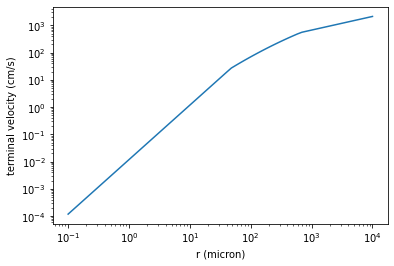

In [5]:
plt.plot(r*1e4,vterminal)
plt.xscale("log")
plt.yscale("log")

plt.xlabel("r (micron)")
plt.ylabel("terminal velocity (cm/s)")
plt.savefig("vterm.pdf", bbox_inches="tight", pad_inches=0.0)
plt.savefig("vterm.png", bbox_inches="tight", pad_inches=0.0)
plt.show()

In the above figure, you see three regimes of the r dependence on the terminal velocity.
For small r, the terminal velocity obeys the Stokes flow.
In the mid - large r (i.e. medium and large Reynolds number Nre), exojax uses a phenomenological modeling as explained below.

We start from importing the the drag coefficients as Nre from Table 10.1 p381 in Pruppacher and Klett
 

In [6]:
data = pd.read_csv("~/exojax/data/clouds/drag_force.txt",comment="#",delimiter=",")

Let's fit logarithms of Davies number $N_D = C_d N_{re}^2$ and Reynolds number $N_{re}$ by a polynomial equation.

In [7]:
Nre=data["Nre"].values
logNre=np.log(Nre) #Reynolds number
Cd=(data["Cd_rigid"].values)
logNd=np.log(Nre**2*Cd)

Cdinf=0.45
Nreinf=np.logspace(3,5,30)
logNreinf=np.log(Nreinf)
logNdinf=np.log(Nreinf**2*Cdinf)

In [8]:
coeff=np.polyfit(logNd,logNre,2)
coeff

array([-0.00883374,  0.84514511, -2.49105354])

These are the coefficient we use in exojax in the mid Nre regime.

i.e.

$\log{N_{re}} = 0.0088 \log^2{N_{D}} + 0.85 \log{N_{D}} + 2.49$

Davies number can be computed using the following function.

In [17]:
from exojax.atm.vterm import Ndavies

g=980.0 #gravity cm/s2
drho=1.0 #condensate density g/cm3
rho=1.29*1.e-3 #atmosphere density g/cm3
vfactor,Tr=vc.calc_vfactor(atm="Air") #we use Air
eta=vc.eta_Rosner(300.0,vfactor) #dynamic viscosity at 300K
r=0.01 #cm
print("Davies number=",Ndavies(r,g,eta,drho,rho))

Davies number= 400.34301797889896


We would obtain a boundary  between the mid Nre regime and the Stokes flow.

In [18]:
#boundary between the Stokes flow and the mid Nre regime
#-0.00883374*xarr**2+(0.84514511-1)*xarr-2.49105354 +log(24) = 0
a=-0.0088 #coeff[0]
b=0.85-1 #coeff[1]-1
c=-2.49+np.log(24.) #coeff[2]+np.log(24.)
logNdc=(-b-np.sqrt(b*b-4*a*c))/(2*a)
Ndc=np.exp(logNdc)   #boundary for Davies number
Nrec=np.exp(logNdc-np.log(24.)) #boundary for Reynolds number

In [19]:
logNdc, Ndc, Nrec

(3.7583482270854875, 42.87754348901474, 1.7865643120422807)

Also, for large Nre, we assume Cd=0.45 following Akerman and Marley 2001. 

In [12]:
#boundary between the mid and large Nre regime
#-0.00883374*xarr**2+(0.84514511-0.5)*xarr-2.49105354 +0.5*log(0.45) = 0
a=-0.0088 #coeff[0]
b=0.85-0.5 #coeff[1]-0.5
c=-2.49+0.5*np.log(0.45) #coeff[2]+0.5*np.log(0.45)
logNde=(-b+np.sqrt(b*b-4*a*c))/(2*a)
Nde=np.exp(logNde)
Nree=np.exp(0.5*logNde-0.5*np.log(0.45))

In [13]:
logNde, Nde, Nree

(11.692270778931425, 119643.38181447262, 515.629888398587)

The following figure shows Davies number - Reynolds number relation we assume in exojax.

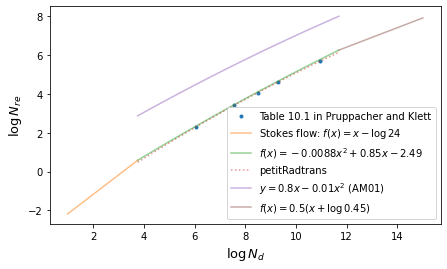

In [22]:
plt.figure(figsize=(7,4))
plt.plot(logNd,logNre,".",label="Table 10.1 in Pruppacher and Klett")

xarr=np.linspace(1,logNdc,100)
plt.plot(xarr,xarr - np.log(24.),alpha=0.5,label="Stokes flow: $f(x)=x-\log{24}$")
xarr=np.linspace(logNdc,logNde,100)
plt.plot(xarr,-0.0088*xarr**2+0.85*xarr-2.49,alpha=0.5,label="$f(x)=-0.0088 x^2+0.85 x-2.49$")
plt.plot(xarr,-2.7905+0.9209*xarr-0.0135*xarr**2,label="petitRadtrans",ls="dotted",alpha=0.5)
plt.plot(xarr,0.8*xarr-0.01*xarr**2,label="$y=0.8x-0.01x^2$ (AM01)",alpha=0.5)

xarr=np.linspace(logNde,15,100)
plt.plot(xarr,0.5*(xarr-np.log(0.45)) ,alpha=0.5,label="$f(x)=0.5(x+\\log{0.45})$  ")
plt.xlabel("$\\log{N_d}$",fontsize=13)
plt.ylabel("$\\log{N_{re}}$",fontsize=13)
plt.legend(loc="lower right")
plt.savefig("davies_reynolds.png")

Notice that there is a typo (?) in Akerman and Marley (2001), tagged by "AM01". 

Using this relation, we can compute the Reynolds number, then we can also compute the terminal velocity using

$v_f(r) = \frac{2}{9 \eta}  g r^2 (\rho_c - \rho) \left( \frac{C_d N_{re}}{24} \right)^{-1}$. 


That's how exojax compute the terminal velocity in exojax.atm.vterm 